# Ejercicio de programación en redes neuronales con los datos MNIST

## Introducción

En este ejercicio usted implementará el algoritmo de "backpropagation" para redes neuronales y aplicarlo a la tarea
de reconocer los dígitos escritos a mano. Antes de comenzar le recomendamos ver los videos de clase con el material cobijado
acá, lo mismo que los videos:

[what is a neural network](https://www.youtube.com/watch?v=aircAruvnKk)
y
[what backpropagation is really doing](https://www.youtube.com/watch?v=Ilg3gGewQ5U)

Toda la información que usted requiere para la solución de este ejercicio está en este cuaderno. El código que vas a implementar está 
también dentro de este cuaderno. 


### Cargar datos y librerías  

In [1]:
# para manipular caminos ("paths")
import os

# para cómputos de vectores y matrices en Python
import numpy as np

# para graficar
from matplotlib import pyplot

# librería de optimización
from scipy import optimize

# esto se usa para cargar datos en formato de MATLAB
from scipy.io import loadmat

# para asegurarse que las gráficas están contenidas en este cuaderno
%matplotlib inline

## Redes Neuronales

Comenzamos cargando los datos

In [2]:
#  cargamos los datos de entrenamiento en los vectores X, y
data = loadmat(os.path.join('Data', 'ex4data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

# Cargamos el 80 por ciento para entrenamiento y 20% para prueba
ochenta=int(X.shape[0]*0.8)
veinte=int(X.shape[0]*0.2)
Xtrain = X[:ochenta]
Xtest = X[ochenta:]
ytrain=y[:ochenta]
ytest=y[ochenta:]

# Number of training examples
m = ytrain.size

In [3]:
Xtest.shape

(1000, 400)

### Visualización de datos

Comenzamos con la visualización de un subconjunto del conjunto de datos.  Los datos originales vienen todos empaquetados en 5000 muestras
las cuales las dividimos en 4000 para entrenamiento y 1000 para prueba. Cada muestra es una imagen de 20x20 pixeles estirada (vectorizada, "unrolled")
por columnas. Cada muestra es una fila de la matriz X. Es decir la matriz X tiene 5000 filas y 400 columnas. De aca obtenemos Xtrain con 4000 milas
y 400 columnas y Xtest con 1000 filas y 400 columnas.  Cada fila representa un dígito entre 0 y 9.

Un diagrama de la matrix X se muestra a continuación.

$$ X = \begin{bmatrix} - \left(x^{(1)} \right)^T - \\
- \left(x^{(2)} \right)^T - \\
\vdots \\
- \left(x^{(m)} \right)^T - \\
\end{bmatrix}
$$

La otra parte de los datos son las etiquetas almacenadas en el vector y. Son 5000 muestras con los dígitos del 0 al 9.
Este conjunto lo dividmos en dos: ytrain de 4000 muestras y ytest con 1000 muestras. 

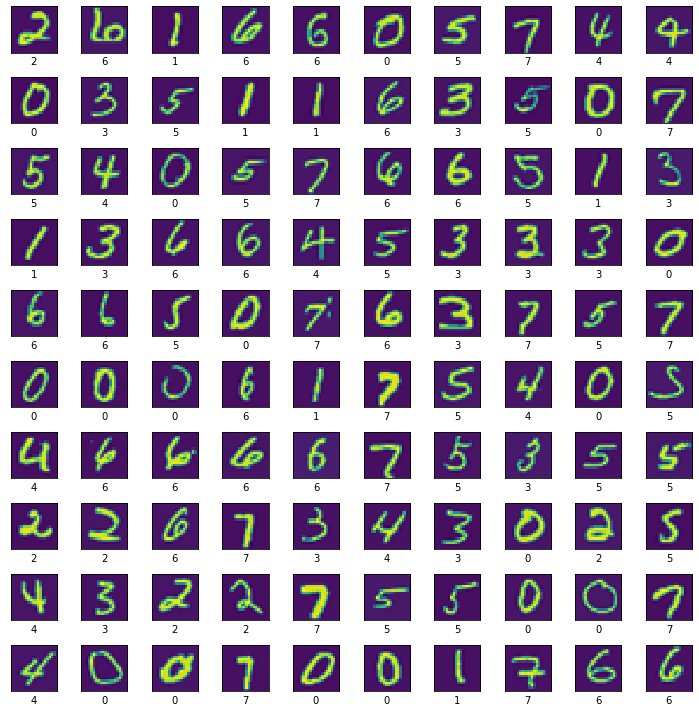

In [4]:
# Escojemos 100 muestras de forma aleatoria
import matplotlib.pyplot as plt
import scipy
rand_indices = np.random.choice(m, 100, replace=False)
sel = Xtrain[rand_indices, :]


plt.figure(figsize=(10,10))

temp = sel.reshape(sel.shape[0], 20, 20)
XtoPlot = temp.transpose(0,2,1)  # the dimensions 1 and 2 are changed
ytoPlot = ytrain[rand_indices]



# grafique 100 (10 x 10) imagenes
for i in range(100):
    plt.subplot(10,10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.tight_layout()
    plt.imshow(XtoPlot[i])
    plt.xlabel("{}".format(ytoPlot[i]))
    
plt.show();

### Representación del modelo

Nuestra red neuronal se muestra en la siguiente figura. 

![neural network](Figures/neural_network.png)

Esta consta de 3 capas (entrada, oculta y salida).  Recuerde que todas las entradas son pixeles que dibujan
imágenes de dígitos. Dado que todas las imágenes tienen dimensiones  $20 \times 20$, tenemos 400 unidades de entrada 
(sin contar el intercepto "bias" +1). 

Para comenzar se le provee un conjunto de pesos ($\Theta^{(1)}, \Theta^{(2)}$)  entrenados. Estos se almacenan en
`ex4weights.mat` y se cargan en la próxima celda en las variables `Theta1` y `Theta2`.  Los parámetros tienen dimensiones
que se acomodan a un red neuronal de 25 unidades en la segunda capa y 10 en la de salida (correspondiente a los 10 dígitos).


In [5]:
Xtrain.shape

(4000, 400)

In [6]:
# parámetros para este ejercicio
input_layer_size  = 400  # 20x20 pixeles
hidden_layer_size = 25   # 25 nodos ocultos
num_labels = 10          # 10 etiquetas de 0 a 9

# cargamos los pesos en las la variables Theta1 y Theta2
weights = loadmat(os.path.join('Data', 'ex4weights.mat'))

# Theta1 tiene tamaño 25 x 401
# Theta2 tiene tamaño  10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# manda la última fila a la primera
# por la forma como MATLAB formatea los datos
Theta2 = np.roll(Theta2, 1, axis=0)

# concatemamos los parametros
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

<a id="section1"></a>
### Propagación hacia adelante y función de costo

Ahora implementarás la función de costo y su gradiente para la red neuronal. Primero complete el código para la función `nnCostFunction`
en la celda que sigue, la cual retorna la función de costo.

Recuerde que la función de costo para una red neuronal (sin regularización) es:
$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

donde  $h_\theta \left( x^{(i)} \right)$ se calcula de acuerdo a la fórmula en la figura de arriba, K¿10 es el número total de etiquetas.
Note que $h_\theta(x^{(i)})_k = a_k^{(3)}$ es la activación (salida) de la unidad $k$. También, como las etiquetas originales en la
variable y son 0,1, ... , 9 , necesitamos codificar las etiquetas en vectores con valores 1 o 0, es decir


$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

Por ejemplo, si $x^{(i)}$ representa una imagen con dígito 5, entonces la etiqueta correspondiente $y^{(i)}$ (que se debe usar en la función
de costo) debería ser un vector 10-dimensional con $y_5=1$ y el resto de elementos iguales a 0.

Usted debe implementar la propagación hacia adelante que calcula $h_\theta(x^{(i)})$ para cada muestra $i$ y la suma de la función de
costo para todas las muestras. **Su código debe trabajar para cualquier conjunto de cualquier tamaño y cualquier número de etiquetas**
(puede asumir que siempre existe, por lo mentos $K \ge 3$ etiquetas)


<div class="alert alert-box alert-warning">
**Nota de implementación:** La matriz $X$ contiene las muestra en las filas (es decir, X[i,:] es la muestra i, $x^{(i)}$, expresada como
    un vector $n \times 1$. Cuando complete el código `nnCostFunction`, necesita agregar la columna de unos "1"s a la matriz X. 
    Los parámetros para cada nodo se representan como Theta1 y Theta2 como una fila. Específicalmente, la primera fila de Theta1 
    corresponde a la primera unidad (nodo) de la segunda capa. Usted puede usar un ciclo "for" sobre las muestras para calcular
    la función de costo.    
</div>
<a id="nnCostFunction"></a>

### Definición  de la función logística (sigmoid) y su gradiente

Para tratar de de ayudarle, en esta parte del ejercicio se implementa
la función "sigmoid" y el gradiente. Recuerde que el gradiente de
la función "sigmoid" se puede implementar como

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$

donde

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

In [7]:
def sigmoid(t):
    # calcula la función logistic (sigmoid)
    return 1/(np.exp(-t)+1)


def sigmoidGradient(z):
    """
    Calcula el gradiente de la función "sigmoid" evaluada en "z".
    Acá "z" puede ser un número, un vector o una matriz.
    

    Parámetros
    ----------
    z : vector
        Un vector o matriz con la entrada a la función sigmoid.
    
    Returna
    --------
    g : vector
        El gradiente de la función sigmoid. Tiene las dimensiones de "z"
    
    Instrucciones
    ------------
    Calcula el gradiente de la función sigmoid evaluado en el punto
    "z" el cual puede ser escalar, vector o matriz. 
    """

    g = np.zeros(z.shape)

    # ====================== SU CÓDIGO ACÁ: 20% ======================

    
    # =============================================================
    return g



In [8]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):
    """
    Implementa la función de costo y su gradiente para la red neuronal con dos
    capas. 
   
    
    Parámetros
    ----------
    nn_params : vector
        Los parámetros de la red neuronal estan "desarrollados" ("unrolled", vectorizados)
        en un vector. Luego necesitamos convertirlos de nuevo a dos matrices Theta1 y Theta2
    nn_params : array_like
    
    input_layer_size : entero
        Número de atributos para la capa de entrada.
    
    hidden_layer_size : entero
        Número de nodos en la segunda (oculta) capa. 
    
    num_labels : entero
        Número total de etiquetas, o equivalentemente número de nodos de salida.
    
    X : vector
        Datos de entrada. Una matriz de dimensiones (m x atributos). Los atributos son input_layer_size.
    
    y : Vector
        Datos con etiquetas. Un vector de tamaño (m,).
    
    lambda_ : real, opcional
        parámetro de regularización.
 
    Returna
    -------
    J : real
        El valor calculado de la función de costo para los pesos actuales dados.
    
    grad : vector
        Un vector ("unrolled") con las derivadas parciales de la concatenación de
        los pesos de las derivadas parciales con los pesos Theta1 y Theta2.
        
    
    Instrucciones:
    ------------
    Debes completar el código siguiento los puntos:
    
    
    - Part 1: Propagar hacia adelante y retornar la función de costo en la variable J.
            Luego puede verificar que la función de costo es correcta comparándola con 
            lo expuesto en la celda de prueba, justo bajo el cálculo de la función de costo.
    
    
    - Part 2: Implementar el algoritmo de propagación hacia atrás (backpropagation) para calcular
              los gradientes Theta1_grad y Theta2_grad. Debe retornar todas las derivadas parciales
              de la función de costo con respecto a Theta1 y Theta2 en las variables
              Theta1_grad y Theta2_grad respectivamente. Luego de esta implementación debe
              verificar que la implementación es correcta corriendo la función 
              `checkNNGradients` que agregamos en este cuaderno. 
    
   
    
              Nota: El vector "y" se pasa a como etiquetas con valores 0,1, .. K-1. 
                    Usted necesita mapear este vector a la forma binaria de 1s y 0s para
                    usarlo en la función de costo.
              
              Ayuda: 
                    Recomendamos la implementación de la propagación hacia atrás
                    en un ciclo "for" sobre todas las muestras de entrenamiento 
                    si lo está haciendo por primera vez. 
             
    
    - Parte 3: Implementar la regularización de la función de costo y sus gradientes.
    
              Ayuda: Usted puede calcular inicialmente los gradientes sin regularización
                     y luego agregarle Theta1_grad y Theta2_grad para la Parte 2.
              
              
    """
    # reconstruir (reshape) las matrices Theta1 y Theta2, apartir de nn_params
    # para nuestra red de dos capas
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    # variables de utilidad
    m = y.size
         
    # necesita retornar las variables correctamente 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    # ====================== SU CÓDIGO ACÁ :  50% ======================
    
 
    # ================================================================
    
   
    # Unroll gradients    
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])
    
    return J, grad

<div class="alert alert-box alert-warning">
Use los siguientes enlaces para moverse a las diferentes partes de este ejercicio que requiere la modificación
de la función  `nnCostFunction`.<br>

regrese a:
- [Propagación hacia adelante y función de costo](#section1)
- [Costo regularizado](#section2)
- [Gradiente de la red neuronal (Backpropagation)](#section4)
- [Gradiente regularizado](#section5)
</div>

Una vez termine puede llamar  `nnCostFunction` usando los parámetros  `Theta1` and `Theta2`. La función de costo debería ser cerca a 0.271462

In [9]:
lambda_ = 0
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, Xtrain, ytrain, lambda_)
print('Parametros de funcion de costo desde ex4weights: %.6f ' % J)
print('El costo deberia ser                   : 0.271462.')

Parametros de funcion de costo desde ex4weights: 0.271462 
El costo deberia ser                   : 0.271462.


<a id="section2"></a>
###  Costo Regularizado

La función de costo para redes neuronales con resgularización está data por:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$

Se puede asumir una función de costo con 3 capas -entrada, oculta y de salida.  Sin embargo, su código debería funcionar
para cualquier número de capas y nodos. Mientras que en este ejercicio listamos los pesos $\Theta^{(1)}$ y $\Theta^{(2)}$ por claridad, note 
que su código debería ser general para matrices  $\Theta^{(1)}$ y $\Theta^{(2)}$  de cualquier tamaño.  Note que no debe regularizar
los términos correspondientes al intercepto ("bias").  Para las matrices  $\Theta^{(1)}$ y $\Theta^{(2)}$ estos corresponden  a la primera columna
en cada matriz.  Agregue la regularización a la función de costo. Note que puede inicialmente calcular la función sin regularizar $J$ usando
la función existente `nnCostFunction` y luego agregar la los términos correspondientes a la regularización . 


Una vez termine puede llamar su `nnCostFunction` usando los parámetros `Theta1` , `Theta2`y  $\lambda = 1$.
Debería obtener un valor cercano a 0.391638.

In [10]:
# Parámetro de regularización.
lambda_ = 1
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                      num_labels, Xtrain, ytrain, lambda_)

print('Parámertro de costo aded): %.6f' % J)
print('Debería estar cerca a                  : 0.391638.')

Parámertro de costo aded): 0.391638
Debería estar cerca a                  : 0.391638.


## 2 Backpropagation (Propagación hacia atrás)

En esta parte usted implementará la propagación hacia atrás (Backpropagation) con el fin de calcular el gradiente de la función de
costo de la red neuronal.  Necesitará actualizar la función de costo `nnCostFunction` de forma que retorne el valor apropiadao para
el `grad`. Una vez tenga el gradiente, debe entrenar la red neuronal mediante la minimización de la función de costo  $J(\theta)$  usando
un optimizador avanzado de `scipy`,  particularmente `optimize.minimize`.  Inicialmente usted debe implementar  la propagación hacia atrás
para calcular los gradientes de los parámetros (no regularizados) de la red neuronal. Luego de verificar el cálculo del gradiente
para el caso no regularizado, debe implementar el caso regularizado para la red neuronal. 


Seguidamente usted debe llamar, en la celda siguiente, `sigmoidGradient`  para un vector `z`. Se prueban algunos valores mediante el llamado
de `sigmoidGradient(z)`. Para valores grandes (positivos o negativos) de z, el gradiente debe ser cercano a 0. Cuando  $z = 0$, el gradiente
debería ser exactamente 0.25. Su código debería trabajar con vectores y matrices. Para una matriz, su función debe operar en cada entrada de
la matriz. 


In [23]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoidGradient(z)
print('Gradiente de la función sigmoid evaluado en  [-1 -0.5 0 0.5 1]:\n  ')
print(g)

Gradiente de la función sigmoid evaluado en  [-1 -0.5 0 0.5 1]:
  
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


## Inicialización aleatoria
Para el entrenamiento de redes neuronales es importante aleatorizar los parámetros con el fin de romper la simetría. Una estrategia efectiva
para esto es seleccionar valores de $\Theta^{(l)}$ uniformemente en un rango $[-\epsilon_{init}, \epsilon_{init}]$. Usted debe usar
$\epsilon_{init} = 0.12$. Este rango de valores asegura que los parámetros son pequeños y el aprendizaje es más eficiente. 


<div class="alert alert-box alert-warning">
Una estrategia efectiva para escoger $\epsilon_{init}$ es basarlo en el número de nodos de la red. Una buena elección es  
$\epsilon_{init}$  como  $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$ donde $L_{in} = s_l$ y $L_{out} = s_{l+1}$ 
corresponde al número de nodos en las capas adjacentes a  $\Theta^{l}$.
    
Su trabajo es completar la función `randInitializeWeights` para inicializar los pesos  $\Theta$. Modifique la función completando el 
código en la próxima celda. 
    
Note que a la función le asignamos un argumento $\epsilon$ con valor, por defecto, `epsilon_init = 0.12`.


In [12]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    """
    Inicializar pesos de una capa de una red neuronal de forma aleatoria.
    
    Parámetros
    ----------
    L_in : entero
        Número de conexiones que entran
    
    L_out : entero
        Número de conexiones que salen.
    
    epsilon_init : real, opcional
        Rango de valores que pueden tomar los pesos en una
        distribución uniforme. 
      
    Retorno
    -------
    W : vector
        Los valores iniciales aleatorios. Noque que W debe
        ser una matriz de tamaño (L_out, 1 + L_in) donde 
        la primera columna de W maneja el intercepto (bias).
       
        
    Instrucciones
    ------------
    Inicializar W de forma aleatoria para romper la simetria mientras
    se entrana la red neuronal. Note que la primera columna de W corresponde
    al "bias". 
    """
    
    # dbe retornan la siguiente vgariable correctamente.
    W = np.zeros((L_out, 1 + L_in))

    # ====================== SU CÓDIGO ACÁ 20% ======================

 

    # ============================================================
    return W

Ejecute la siguiente celda para inicializar los pesos de las dos capas mediante el llamado a  `randInitializeWeights` f

In [24]:
print('Inicializando los parámetros de la red neuronal. ...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Inicializando los parámetros de la red neuronal. ...


<a id="section4"></a>
### Propagación hacia atrás  (Backpropagation)

![backpropagation](Figures/ex4-backpropagation.png)

A continuación usted debe implementar el algoritmo de "backpropagation".  Recuerde que la intuición de este algoritmo es como sigue.
Data un muestra $(x^{(t)}, y^{(t)})$, generamos la propagación hacia adelante para calcular la activación a lo largo de la red, incluyendo
la salida como hipótesis $h_\theta(x)$. Luego, para cada node $j$ de la capa $l$ queremos estimar el "término error" $\delta_j^{(l)}$  el cual
mide que tan "responsable" es ese nodo de los errores en la salida. 

Para cada nodo de salida podemos medir directamente la diferencia entre la activación de la red y el valor meta (la etiqueta). Usamos este para definir
$\delta_j^{(3)}$ (datdo que la capa 3 es la salida). Para los nodos ocultos, debe calcular $\delta_j^{(l)}$ basado en los pesos promedio de los términos de error
de los nodos en la capa $(l+1)$. En detalle, debe implementar un ciclo `for t in range(m)`  con los pasos 1-4 dentro del ciclo, con la iteración $t$ que calcula
el resultado en la muestra $t$ ,  $(x^{(t)}, y^{(t)})$. El paso 5 divide los gradientes acumulados por $m$ para obtenter los gradientes de la red neuronal.

1. Asigne los valores $(a^{(1)})$ de la capa de entrada a la muestra $t$, $x^{(t)}$. Ejecute la propagación hacia adelante, mediante el cálculo
de las activaciones  $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ para las capas 2 y 3. Note que necesita agreagar el valor $+1$ para asegurar que las activaciones de la
las capas $a^{(1)}$ y $a^{(2)}$ incluyen el "bias". En `numpy`, si 1 es una columna, agragar esta columna se puede hacer con la instrucción:
`a_1 = np.concatenate([np.ones((m, 1)), a_1], axis=1)`.

2. Para cada nodo de salida $k$ en la capa 3 (capa de salida), haga
$$\delta_k^{(3)} = \left(a_k^{(3)} - y_k \right)$$
donde $y_k \in \{0, 1\}$ indica si la muestra presente pertenece a la clase $k$  $(y_k = 1)$, o si pertenece a otra clase $(y_k = 0)$. 
Podría encontrar los vectores lógicos, explicados en el ejercicio anterior, útiles para esta tarea.

3. Para la capa oculta $l=2$, haga
$$ \delta^{(2)} = \left( \Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$
Note que el símbolo $*$ multiplica componente-a-componente en `numpy`.

4. Acumule el gradiente para esta muestra. Note que que debe remover
 $\delta_0^{(2)}$. En `numpy`, remover $\delta_0^{(2)}$ corresponde a  `delta_2 = delta_2[1:]`.


5. Obtenta el gradiente no regularizado para la función de costo de la red neuronal normalizando , es decir,
$\frac{1}{m}$:
$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$




Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$:
$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$

<div class="alert alert-box alert-warning">

**Python/Numpy tip**:Debe implementar la propagación hacia atrás solo luego de tener una propagación hacia adelante exitosa. Mientras implementa
    la propagación hacia atrás, es útil  usar la función `shape` para imprimir las dimensiones de las variables con las cuales está trabajando y
    depurar mensajes de error debido a dimensiones incorrecta.s 
    
</div>


Luego de que implemente el algoritmo de propagación hacia atrás, procedemos a verificar su implentación. Esta prueba ayudará a obtener confianza en la forma correcta como
debe correr el programa. 


### Verificación del gradiente 

En una red neuronral, usted minimiza la función de costo $J(\Theta)$. Para probar el gradiente en sus parámetros imagine "desarrollar" ("unrolling") los parámetros
$\Theta^{(1)}$, $\Theta^{(2)}$ en un vector largo $\theta$. De esta forma usted puede pensar en la función de costo $J(\Theta)$ y usar el siguiente procedimiento.

Asuma que tiene una función $f_i(\theta)$  que supuestamente calcula $\frac{\partial}{\partial \theta_i} J(\theta)$; usted quiere verificar si $f_i$ es la
salida correcta de laas derivadas. 

$$
\text{Let } \theta^{(i+)} = \theta + \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
\quad \text{and} \quad \theta^{(i-)} = \theta - \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
$$

En este sentido , $\theta^{(i+)}$ es igual a  $\theta$, excepto que su $i$ elemento se incrementó en $\epsilon$. Similarmente
 $\theta^{(i−)}$  es el valor correspondiente del vector con la $i$ muestra reducida por $\epsilon$. Luego, usted puede ahora verificar
 que $f_i(\theta)$’s  es correcto para cada $i$. Es decir. 


$$ f_i\left( \theta \right) \approx \frac{J\left( \theta^{(i+)}\right) - J\left( \theta^{(i-)} \right)}{2\epsilon} $$

El grado en que estos valores se aproximan entre si depende de los detalles de $J$. Asumiendo que $\epsilon = 10^{-4}$, debe encontrar
que las dos columnas (izquierda y derecha) deben coincidir con por lo menos 4 digitos significantes (y a menudo mas).

Aca implementamos la función que calcula el gradiente numérico `computeNumericalGradient`. Usted no debe modificar esta función pero
es bueno que la estudie y entienda como trabaja. 

En la próxima celda debe correr la función `checkNNGradients`  la cual crea un red pequeña y datos que serán usados para verficiar
sus gradientes. Si su propagación hacia atrás es correcta usted deberiá tener un error menor que 1e-9.


<div class="alert alert-box alert-success">
**Consejo práctico**:  Cuando haga la verificación del gradiente, es mucho más eficiente usar redes neuronales pequeñas con un número
    relativamente pequeño de nodos de entrada y ocultos, de esta forma obteniendo un número pequeño de parámetros. 
    Cada dimensión de $\theta$ requiere dos evaluaciones de la función de costo y esto puede ser costoso. En la función 
    `checkNNGradients`, el código crea un modelo pequeño aleatorio y unos data que son usados con `computeNumericalGradient` para la verificación
    del gradiente. Admás, luego de que usted esté convencido de que el gradiente es correcto, debería ocultar la verificación
    antes de correr el algoritmo real.
    
  
</div>

<div class="alert alert-box alert-success">
**Consejo Práctico:**  La verificación del gradiente trabajar para una función de costo. Concretamente, usted puede usar la misma función `computeNumericalGradient`
    para verificar si la implementación del gradiente para otros ejercicioes es correcta también (por ejemplo, en la función de costo de regresión logística)

</div>

In [26]:
def debugInitializeWeights(fan_out, fan_in):
    """
    Inicialización de los pesos de una capa que recibe un abanico de entrada y uno de salida.
    Esto le puede ayudar a depurar el programa. 
    
    Note que W debería ser una matriz de tamaño (1+abanico_entrada, abanico_salida) donde la
    primera fila de W maneja los términos de "bias".
    

    Parámetros
    ----------
    fan_out : entero
        El número de conexiones de salida.

    fan_in : entero
        Número de conexiones de entrada.

    Retorna
    -------
    W : vector  (1+abanico_entrrada, abanico_salida)
        
    """
    # Inicialice W usando "sin". Esto asegura que W es conserva valores pequeños en el mismo rango.
    # util para depuración.
    W = np.sin(np.arange(1, 1 + (1+fan_in)*fan_out))/10.0
    W = W.reshape(fan_out, 1+fan_in, order='F')
    return W


def computeNumericalGradient(J, theta, e=1e-4):
    """
    Calcula el gradiente de forma numérica usando diferencias finitas.
    
    
    Parámetros
    ----------
    J : función real
        Función de costo para evaluar el gradiente numérico.

    theta : Vector
            El vector "desarrollado" con los parámetros de la red. 
            El gradiente numérico se calcula en estos parámetros. 
    
    
    e : real (opcional)
        El valor de epsilon para calcular las diferencias finitas. 
    
    Notas
    -----
    La implementación a continuación tiene como objeto verificar el gradiente.
    Esta retorna el valor del gradiente. Asigna `numgrad[i]` a (una aproximación
    numérica) a la derivada parcial de $J$ con respecto a la $i$ componente
    del argumento de entrada $\Theta$. Es decir, `numgrad[i]` reprenta
    la derivada parcial de $J$ con respecto a theta[i].
    
    
    """
    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape))
    for i in range(theta.size):
        loss1, _ = J(theta - perturb[:, i])
        loss2, _ = J(theta + perturb[:, i])
        numgrad[i] = (loss2 - loss1)/(2*e)
    return numgrad


def checkNNGradients(nnCostFunction, lambda_=0):
    """
    Esta función crea una red neuronal pequeña con el fin de propagar el gradiente
    de propagación hacia atrás. Arroja los gradientes analíticos producidos por la propagación
    y los numéricos calculados con computeNumericalGradient). Estos dos gradientes 
    deben ser muy similares. 
    
    

    Parámetros
    ----------
    nnCostFunction : función
                    Una referencia a la función de costo implementada por el estudiante. 
    


    lambda_ : real (opcional)
        parámetro de regularización. 
    """
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # generamos datos aleatorios
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)

    # reusamos debugInitializeWeights para generar X
    X = debugInitializeWeights(m, input_layer_size - 1)
    y = np.arange(1, 1+m) % num_labels
    # print(y)
    # Unroll (desarrollar) parameters
    nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

    # alias de la función de costo
    costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size,
                                        num_labels, X, y, lambda_)
    cost, grad = costFunc(nn_params)
    numgrad = computeNumericalGradient(costFunc, nn_params)

    # Visualmente exmine las dos columnas (que son el gradiente) deben ser muy similares. 
    print(np.stack([numgrad, grad], axis=1))
    print('The above two columns you get should be very similar.')
    print('(Left-Your Numerical Gradient, Right-Analytical Gradient)\n')

    # Evalúe la norma de las diferencias entre las dos soluciones. Si su
    # implementación es correcta y asumiendo e=0.0001 en computeNumericalGradient
    # la diferencia debe ser menor que 1e-9
    diff = np.linalg.norm(numgrad - grad)/np.linalg.norm(numgrad + grad)
    
    print('si su propagación hacia atrás es correcta \n'
          'la diferencia debe ser pequeña(<1e-9). \n'
          'Diferencia : %g' % diff)

   

In [27]:
checkNNGradients(nnCostFunction)

[[-9.27825235e-03 -9.27825236e-03]
 [-3.04978709e-06 -3.04978914e-06]
 [-1.75060084e-04 -1.75060082e-04]
 [-9.62660640e-05 -9.62660620e-05]
 [ 8.89911959e-03  8.89911960e-03]
 [ 1.42869450e-05  1.42869443e-05]
 [ 2.33146358e-04  2.33146357e-04]
 [ 1.17982666e-04  1.17982666e-04]
 [-8.36010761e-03 -8.36010762e-03]
 [-2.59383093e-05 -2.59383100e-05]
 [-2.87468729e-04 -2.87468729e-04]
 [-1.37149709e-04 -1.37149706e-04]
 [ 7.62813550e-03  7.62813551e-03]
 [ 3.69883257e-05  3.69883234e-05]
 [ 3.35320351e-04  3.35320347e-04]
 [ 1.53247082e-04  1.53247082e-04]
 [-6.74798369e-03 -6.74798370e-03]
 [-4.68759764e-05 -4.68759769e-05]
 [-3.76215583e-04 -3.76215587e-04]
 [-1.66560294e-04 -1.66560294e-04]
 [ 3.14544970e-01  3.14544970e-01]
 [ 1.64090819e-01  1.64090819e-01]
 [ 1.64567932e-01  1.64567932e-01]
 [ 1.58339334e-01  1.58339334e-01]
 [ 1.51127527e-01  1.51127527e-01]
 [ 1.49568335e-01  1.49568335e-01]
 [ 1.11056588e-01  1.11056588e-01]
 [ 5.75736494e-02  5.75736493e-02]
 [ 5.77867378e-02  5

* Una vez su función de costo pasa la verificación del gradiente (no regularizado) estamos listos para implementar la función de costo de gradiente para la red neuronal regularizada*


<a id="section5"></a>
### Red regularizada

Luego de la implementación existosa del algoritmo de propagación usted debe agregar el término de regularización. 
Específicamente, luego de que calcule  $\Delta_{ij}^{(l)}$ mediante el uso de propagación hacia atrás, usted debe regularizar usando


$$ \begin{align} 
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} & \qquad \text{for } j = 0 \\
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} \Theta_{ij}^{(l)} & \qquad \text{for } j \ge 1
\end{align}
$$

Note que usted no debe regularizar la primera columna de $\Theta^{(l)}$ la cual se usa solo para el "bias". Además, en los parámetros  $\Theta_{ij}^{(l)}$, $i$ 
comienza desde 1 y $j$ desde 0, de forma que:

$$
\Theta^{(l)} = \begin{bmatrix}
\Theta_{1,0}^{(i)} & \Theta_{1,1}^{(l)} & \cdots \\
\Theta_{2,0}^{(i)} & \Theta_{2,1}^{(l)} & \cdots \\
\vdots &  ~ & \ddots
\end{bmatrix}
$$

En este momento por favor modifique la función de costo `nnCostFunction` para agregar la regularización. 
Luego de hacer esto, la celda siguiente verifica su implementación. Si su código es correcto, usted debería obtener un error (norma) menor que 1e-9.

In [28]:
#  Check gradients by running checkNNGradients
lambda_ = 3
checkNNGradients(nnCostFunction, lambda_)

# Also output the costFunction debugging values
debug_J, _  = nnCostFunction(nn_params, input_layer_size,
                          hidden_layer_size, num_labels, X, y, lambda_)

print('\n\nCost at (fixed) debugging parameters (w/ lambda = %f): %f ' % (lambda_, debug_J))
print('(for lambda = 3, this value should be about 0.576051)')

[[-9.27825235e-03 -9.27825236e-03]
 [-1.67679797e-02 -1.67679797e-02]
 [-6.01744725e-02 -6.01744725e-02]
 [-1.73704651e-02 -1.73704651e-02]
 [ 8.89911959e-03  8.89911960e-03]
 [ 3.94334829e-02  3.94334829e-02]
 [-3.19612287e-02 -3.19612287e-02]
 [-5.75658668e-02 -5.75658668e-02]
 [-8.36010761e-03 -8.36010762e-03]
 [ 5.93355565e-02  5.93355565e-02]
 [ 2.49225535e-02  2.49225535e-02]
 [-4.51963845e-02 -4.51963845e-02]
 [ 7.62813550e-03  7.62813551e-03]
 [ 2.47640974e-02  2.47640974e-02]
 [ 5.97717617e-02  5.97717617e-02]
 [ 9.14587966e-03  9.14587966e-03]
 [-6.74798369e-03 -6.74798370e-03]
 [-3.26881426e-02 -3.26881426e-02]
 [ 3.86410548e-02  3.86410548e-02]
 [ 5.46101547e-02  5.46101547e-02]
 [ 3.14544970e-01  3.14544970e-01]
 [ 1.18682669e-01  1.18682669e-01]
 [ 2.03987128e-01  2.03987128e-01]
 [ 1.25698067e-01  1.25698067e-01]
 [ 1.76337550e-01  1.76337550e-01]
 [ 1.32294136e-01  1.32294136e-01]
 [ 1.11056588e-01  1.11056588e-01]
 [ 3.81928689e-05  3.81928696e-05]
 [ 1.17148233e-01  1

### Aprendiendo parámetros mediante el uso de  `scipy.optimize.minimize`

Luego de que halla implementado correctamente el gradiente de la función de costo
de la red neuronal, el próximo paso es usar `scipy` para minimizar un buen conjunto de parámetros. 


In [29]:
# Luego de completar su tarea, cambie el maxiter a un número mas grande
#  para ver como ayuda el entrenamiento.
options= {'maxiter': 100}

#  Usted debe tratar valores diferentes de lambda
lambda_ = 1

# Cree un alias para la función de costo minimizada
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, Xtrain, ytrain, lambda_)

# En este momento la función de costo toma solo un argumento
# (los parámetros de la red neuronal)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# obtenga la  solución de la optimización
nn_params = res.x

# Obtenga Theta1 y Theta2 de nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

Luego de completar el entrenamiento debemos reportar el "accuracy" del clasificador mediante el cómputo de porcentaje de muestras correctas.
Si su implementación es correcta usted debería tener una precisión cercana al 97.78% (esto podría cambiar cerca del 1% debido a la inicialización aleatoria).
Es posible obtener precisiones mayores incrementando el número de iteraciones. Lo animamos a que trate esta posibilidad (por ejemplo usando
`maxiter`=400) . También se puede jugar con el parámetro de regularización $\lambda$.


In [32]:
def predict(Theta1, Theta2, X):
    """
    Prediga la etiqueta de entrada mediante el uso de los parametros
    de red nueronal theta. 
   
    """
    # valores útiles
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # Debe retornar las siguientes variables correctamente
    p = np.zeros(m)
    h1 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), X], axis=1), Theta1.T))
    h2 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), h1], axis=1), Theta2.T))
    p = np.argmax(h2, axis=1)
    return p

pred = predict(Theta1, Theta2, Xtrain)
print('Training Set Accuracy: %f' % (np.mean(pred == ytrain) * 100))

Training Set Accuracy: 97.775000


## Visualización de la capa oculta

Una manera de entender que está aprendiendo una red neuronal es mediante la visualización de las representaciones capturadas por la capa oculta.
Informalmente, data una neurona particular, uno puede visualizarla teniendo en cuenta la entrada $x$ que causa su activación ( es decir el valor
de activación ($a_i^{(l)}$) close to 1). Para la red neuronal que usted entrenó , note que la fila $i$ de $\Theta^{(1)}$ es un vector de 401 dimensiones
que representa la neurona oculta $i$. Si descartamos el término del "bias" obtenemos un vector de 400 dimensiones que representa cada
pixel de la capa oculta. 

De esta forma uno puede visualizar la "representación" capturada por la capa oculta luego de re-formatearla a una imagen de 20 x 20.
Esta capa produce la mayor activación.

La próxima celta hace esto 



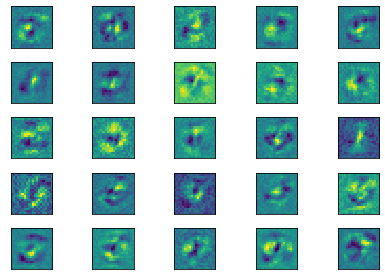

In [19]:
Theta11 = Theta1[:,1:]

T = Theta11.reshape(Theta11.shape[0], 20, 20)
T2 = T.transpose(0,2,1)  # the dimensions 1 and 2 are changed

# grafique 100 (10 x 10) imagenes
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.tight_layout()
    plt.imshow(T2[i])

plt.show();

In [20]:
# T = Theta1.reshape(Theta11.shape[0], 20, 20)
Theta11.shape
T = Theta11.reshape(Theta11.shape[0], 20, 20)



(25, 400)

# Verificación del entrenamiento con unas pocas imágenes

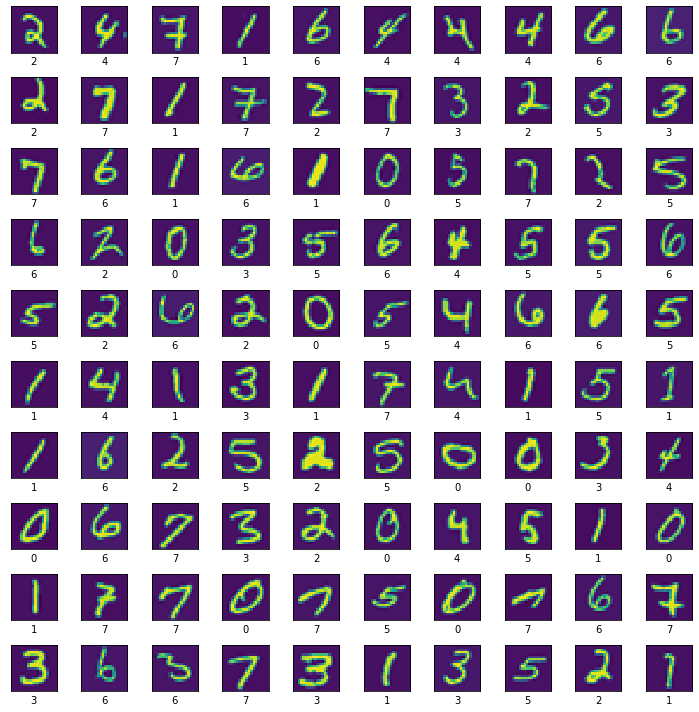

In [33]:
# Selecciones 100 índices aleatoriamente
import matplotlib.pyplot as plt
from matplotlib import transforms  # los datos son rotados
import scipy
rand_indices = np.random.choice(m, 100, replace=False)
sel = Xtrain[rand_indices, :]



plt.figure(figsize=(10,10))

temp = sel.reshape(sel.shape[0], 20, 20)
XtoPlot = temp.transpose(0,2,1)  # intercambio de dimensiones 1 con 2
ytoPlot = pred[rand_indices]



# grafique 100 (10 x 10) imagenes
for i in range(100):
    plt.subplot(10,10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.tight_layout()
    plt.imshow(XtoPlot[i])
    plt.xlabel("{}".format(ytoPlot[i]))
    
plt.show();

### Prueba( Testing)
En la siguiente celtra use los datos de prueba Xtest para probar el algoritmo en ellos,
pues esos datos no se usaron en el entrenamiento.
Verifique que la precision es 0!!!!

In [22]:
    # ====================== SU CÓDIGO ACÁ 10% ======================

    # =================================================================


Training Set Accuracy: 0.000000


Pregunta:
¿Por que la precisión (accuracy) obtenida es 0?

Extra-crédito (20 puntos).
Arregle el problema para que la precisión (accuracy) no sea 0. 